In [25]:
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, classification_report, confusion_matrix, RocCurveDisplay)
from sklearn.svm import SVC
from sklearn.decomposition import PCA
import joblib

# Pretty plots
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True
sns.set_context("notebook")


In [27]:
def infer_target_column(df: pd.DataFrame) -> str:
    """Try to detect the binary target column."""
    candidates = [
        "diagnosis","Diagnosis","target","Target","Class","class","label","Label",
        "Outcome","outcome","status","Status","benign_malignant","result","Result","target_class"
    ]
    for c in candidates:
        if c in df.columns and df[c].dropna().nunique() == 2:
            return c
    # fallback: last column with 2 or 3 unique values, else last column
    for c in df.columns[::-1]:
        if df[c].dropna().nunique() in (2, 3):
            return c
    return df.columns[-1]

def encode_target(y_raw: pd.Series):
    """Map positive class to 1 using common keywords, else first label as positive."""
    unique_vals = list(pd.Series(y_raw.unique()).dropna())
    pos_keywords = {"m","malignant","yes","1","present","cancer","true","recur","recurrence-events"}
    lower_map = {str(v).strip().lower(): v for v in unique_vals}
    pos_label = None
    for key in lower_map:
        if key in pos_keywords:
            pos_label = lower_map[key]; break
    if pos_label is None:
        pos_label = unique_vals[0]
    mapping = {v: (1 if v == pos_label else 0) for v in unique_vals}
    y = y_raw.map(mapping).fillna(0).astype(int)
    return y.values.astype(int), mapping

def build_preprocessor(X: pd.DataFrame) -> ColumnTransformer:
    """Scale numeric, impute; one-hot encode categorical; robust to mixed data."""
    num_features = selector(dtype_include=np.number)(X)
    cat_features = selector(dtype_exclude=np.number)(X)
    num_pipe = Pipeline([("imputer", SimpleImputer(strategy="median")),
                         ("scaler", StandardScaler())])
    cat_pipe = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                         ("ohe", OneHotEncoder(handle_unknown="ignore"))])
    return ColumnTransformer([("num", num_pipe, num_features),
                              ("cat", cat_pipe, cat_features)])

def cv_summary(pipe, X, y, cv, scoring=None):
    if scoring is None:
        scoring = {"accuracy":"accuracy", "precision":"precision", "recall":"recall", "f1":"f1", "roc_auc":"roc_auc"}
    scores = cross_validate(pipe, X, y, scoring=scoring, cv=cv, n_jobs=-1)
    out = {k.replace("test_", ""): (float(np.mean(v)), float(np.std(v)))
           for k, v in scores.items() if k.startswith("test_")}
    return out

def print_cv_summary(name, summary):
    print(f"\n{name} — 5-Fold CV (mean ± std)")
    for m, (mu, sd) in summary.items():
        print(f"  {m:>9}: {mu:.4f} ± {sd:.4f}")

def plot_confusion(cm, class_names, title="Confusion Matrix"):
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                     xticklabels=class_names, yticklabels=class_names,
                     cbar=False, linewidths=1, linecolor='gray')
    ax.set_xlabel("Predicted"); ax.set_ylabel("Actual"); ax.set_title(title)
    plt.tight_layout(); plt.show()

def fit_and_eval(model, X_train, y_train, X_test, y_test, class_names=None, prefix="model", outdir=Path("outputs")):
    outdir.mkdir(exist_ok=True, parents=True)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    metrics = {
        "accuracy": float(accuracy_score(y_test, y_pred)),
        "precision": float(precision_score(y_test, y_pred)),
        "recall": float(recall_score(y_test, y_pred)),
        "f1": float(f1_score(y_test, y_pred)),
    }

    # score for ROC
    y_score = None
    if hasattr(model, "decision_function"):
        try:
            y_score = model.decision_function(X_test)
        except Exception:
            y_score = None
    if y_score is None and hasattr(model, "predict_proba"):
        try:
            y_score = model.predict_proba(X_test)[:, 1]
        except Exception:
            y_score = None

    if y_score is not None:
        metrics["roc_auc"] = float(roc_auc_score(y_test, y_score))

    print(f"\n[{prefix}] Test Metrics")
    for k, v in metrics.items():
        print(f"  {k:>9}: {v:.4f}")

    # report & confusion matrix
    print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))
    cm = confusion_matrix(y_test, y_pred)
    if class_names is None:
        class_names = ["Class 0", "Class 1"]
    plot_confusion(cm, class_names, title=f"{prefix} — Confusion Matrix")

    # ROC curve
    if y_score is not None:
        RocCurveDisplay.from_predictions(y_test, y_score)
        plt.title(f"ROC Curve — {prefix}")
        plt.tight_layout(); plt.show()

    # save artifacts
    (outdir / "metrics").mkdir(exist_ok=True, parents=True)
    with open(outdir / "metrics" / f"{prefix}_metrics.json", "w") as f:
        json.dump(metrics, f, indent=2)
    np.savetxt(outdir / "metrics" / f"{prefix}_confusion_matrix.csv", cm, delimiter=",", fmt="%d")

    return metrics

def plot_decision_boundary_2d(X, y, kernel, outputs_dir: Path, title_prefix: str):
    """PCA to 2D for visualization, then SVC on the 2D space just for plotting."""
    preprocessor = build_preprocessor(X)
    pca = PCA(n_components=2, random_state=42)
    full_pipe = Pipeline([("prep", preprocessor), ("pca", pca)])
    X2 = full_pipe.fit_transform(X)

    clf = SVC(kernel=kernel, probability=True, class_weight="balanced", random_state=42)
    clf.fit(X2, y)

    x_min, x_max = X2[:, 0].min() - 1.0, X2[:, 0].max() + 1.0
    y_min, y_max = X2[:, 1].min() - 1.0, X2[:, 1].max() + 1.0
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 400),
                         np.linspace(y_min, y_max, 400))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = clf.predict(grid).reshape(xx.shape)

    plt.figure()
    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X2[:, 0], X2[:, 1], c=y, s=14, alpha=0.85, edgecolor="k", linewidth=0.2)
    plt.title(f"{title_prefix} — Decision Boundary ({kernel.upper()} kernel)")
    plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.tight_layout()
    outputs_dir.mkdir(exist_ok=True, parents=True)
    plt.savefig(outputs_dir / f"decision_boundary_{kernel}.png", dpi=150)
    plt.show()


In [28]:
csv_candidates = [
    "breast-cancer.csv", "breast_cancer.csv", "Breast_Cancer.csv",
    "data.csv", "wdbc.csv"
]

df = None
for name in csv_candidates:
    p = Path(name)
    if p.exists():
        df = pd.read_csv(p)
        print(f"Loaded: {p}")
        break

if df is None:
    raise FileNotFoundError("CSV not found. Put the Kaggle breast cancer CSV next to this notebook (e.g., 'breast-cancer.csv').")

print("Shape:", df.shape)
display(df.head())
print("\nColumns:", list(df.columns))

# Drop obvious non-features
cols_to_drop = [c for c in df.columns if 'unnamed' in c.lower()]
if 'id' in df.columns: cols_to_drop.append('id')
df = df.drop(columns=cols_to_drop, errors='ignore')
print("\nAfter dropping non-feature columns:", df.shape)



Loaded: breast-cancer.csv
Shape: (569, 32)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678



Columns: ['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst']

After dropping non-feature columns: (569, 31)


In [29]:
target_col = infer_target_column(df)
print("Detected target column:", target_col)

y_raw = df[target_col]
X = df.drop(columns=[target_col])

y, mapping = encode_target(y_raw)
print("Target mapping (original -> encoded):", mapping)

print("\nTarget distribution (encoded):")
print(pd.Series(y).value_counts().sort_index().rename({0: "Class 0", 1: "Class 1"}))


Detected target column: diagnosis
Target mapping (original -> encoded): {'M': 1, 'B': 0}

Target distribution (encoded):
Class 0    357
Class 1    212
Name: count, dtype: int64


In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)
X_train.shape, X_test.shape


((455, 30), (114, 30))

In [31]:
preprocessor = build_preprocessor(X_train)

svm_linear = Pipeline([
    ("prep", preprocessor),
    ("clf", SVC(kernel="linear", probability=True, class_weight="balanced", random_state=42))
])

svm_rbf = Pipeline([
    ("prep", preprocessor),
    ("clf", SVC(kernel="rbf", probability=True, class_weight="balanced", random_state=42))
])

# 5-fold stratified CV on train set
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
lin_cv = cv_summary(svm_linear, X_train, y_train, cv)
rbf_cv = cv_summary(svm_rbf,   X_train, y_train, cv)

print_cv_summary("Linear SVM", lin_cv)
print_cv_summary("RBF SVM",    rbf_cv)



Linear SVM — 5-Fold CV (mean ± std)
   accuracy: 0.9648 ± 0.0108
  precision: 0.9596 ± 0.0223
     recall: 0.9471 ± 0.0432
         f1: 0.9523 ± 0.0159
    roc_auc: 0.9947 ± 0.0049

RBF SVM — 5-Fold CV (mean ± std)
   accuracy: 0.9692 ± 0.0108
  precision: 0.9646 ± 0.0101
     recall: 0.9529 ± 0.0353
         f1: 0.9583 ± 0.0154
    roc_auc: 0.9948 ± 0.0043



[baseline_linear] Test Metrics
   accuracy: 0.9737
  precision: 0.9756
     recall: 0.9524
         f1: 0.9639
    roc_auc: 0.9914

Classification Report:
               precision    recall  f1-score   support

           0     0.9726    0.9861    0.9793        72
           1     0.9756    0.9524    0.9639        42

    accuracy                         0.9737       114
   macro avg     0.9741    0.9692    0.9716       114
weighted avg     0.9737    0.9737    0.9736       114



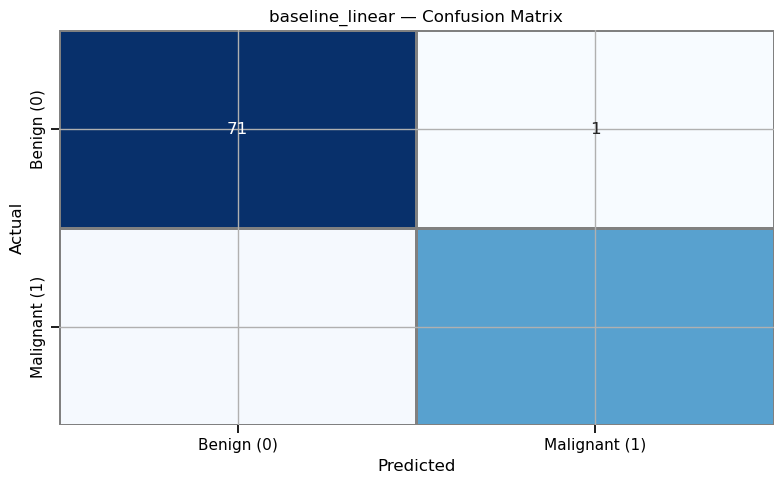

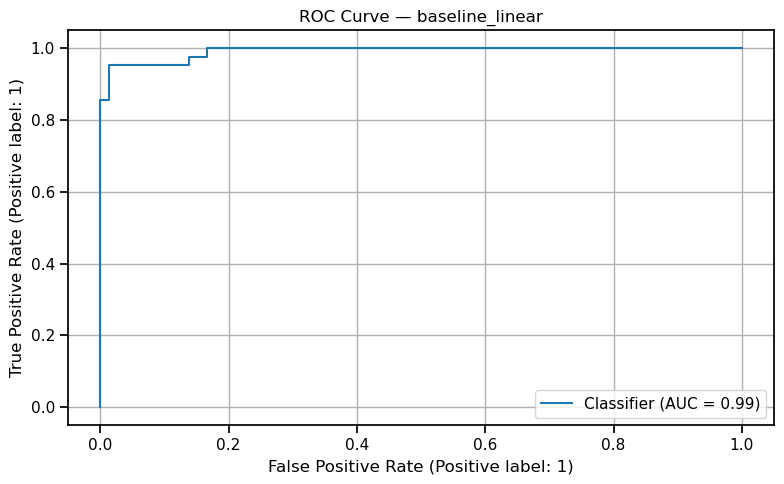


[baseline_rbf] Test Metrics
   accuracy: 0.9825
  precision: 0.9762
     recall: 0.9762
         f1: 0.9762
    roc_auc: 0.9954

Classification Report:
               precision    recall  f1-score   support

           0     0.9861    0.9861    0.9861        72
           1     0.9762    0.9762    0.9762        42

    accuracy                         0.9825       114
   macro avg     0.9812    0.9812    0.9812       114
weighted avg     0.9825    0.9825    0.9825       114



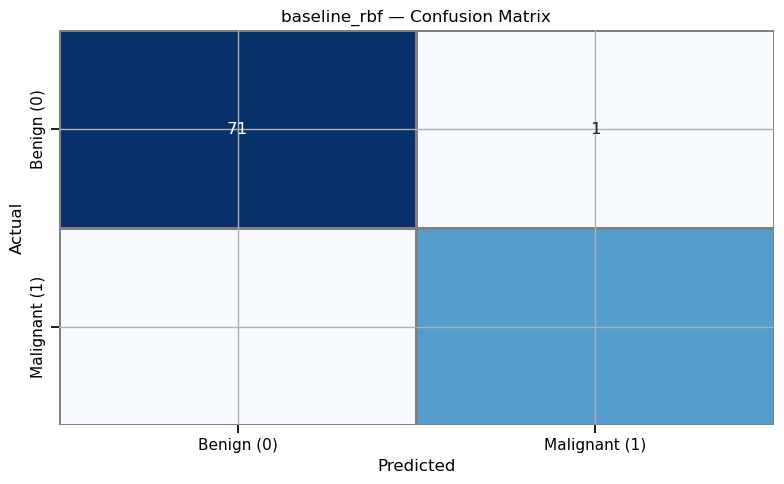

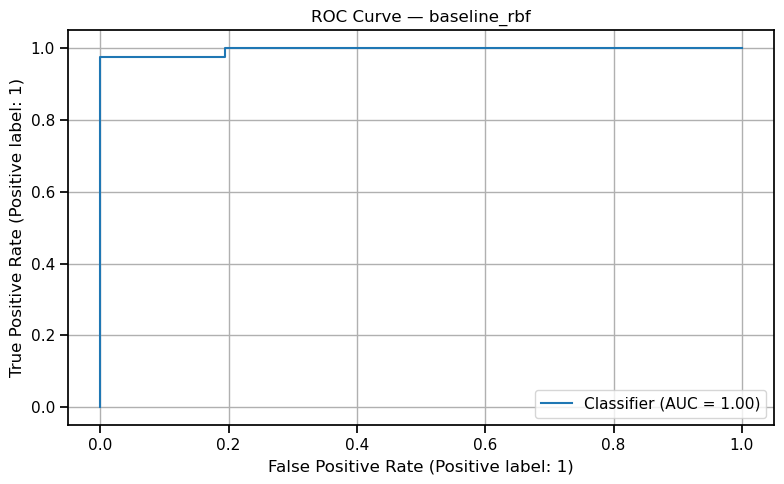

In [32]:
class_names = ["Benign (0)", "Malignant (1)"]  # typical for this dataset; safe for 0/1

metrics_linear_base = fit_and_eval(svm_linear, X_train, y_train, X_test, y_test,
                                   class_names=class_names, prefix="baseline_linear", outdir=Path("outputs"))
metrics_rbf_base    = fit_and_eval(svm_rbf,    X_train, y_train, X_test, y_test,
                                   class_names=class_names, prefix="baseline_rbf", outdir=Path("outputs"))


In [33]:
param_grid_linear = {
    "clf__C": [0.01, 0.1, 1, 10, 100]
}
gs_linear = GridSearchCV(svm_linear, param_grid_linear, scoring="f1", cv=cv, n_jobs=-1)
gs_linear.fit(X_train, y_train)
print("Linear best params:", gs_linear.best_params_)
print("Linear best CV (F1):", f"{gs_linear.best_score_:.4f}")

param_grid_rbf = {
    "clf__C": [0.01, 0.1, 1, 10, 100],
    "clf__gamma": ["scale", "auto", 0.001, 0.01, 0.1, 1.0]
}
gs_rbf = GridSearchCV(svm_rbf, param_grid_rbf, scoring="f1", cv=cv, n_jobs=-1)
gs_rbf.fit(X_train, y_train)
print("RBF best params:", gs_rbf.best_params_)
print("RBF best CV (F1):", f"{gs_rbf.best_score_:.4f}")


Linear best params: {'clf__C': 0.01}
Linear best CV (F1): 0.9641
RBF best params: {'clf__C': 10, 'clf__gamma': 0.01}
RBF best CV (F1): 0.9730



[tuned_linear] Test Metrics
   accuracy: 0.9912
  precision: 1.0000
     recall: 0.9762
         f1: 0.9880
    roc_auc: 0.9980

Classification Report:
               precision    recall  f1-score   support

           0     0.9863    1.0000    0.9931        72
           1     1.0000    0.9762    0.9880        42

    accuracy                         0.9912       114
   macro avg     0.9932    0.9881    0.9905       114
weighted avg     0.9913    0.9912    0.9912       114



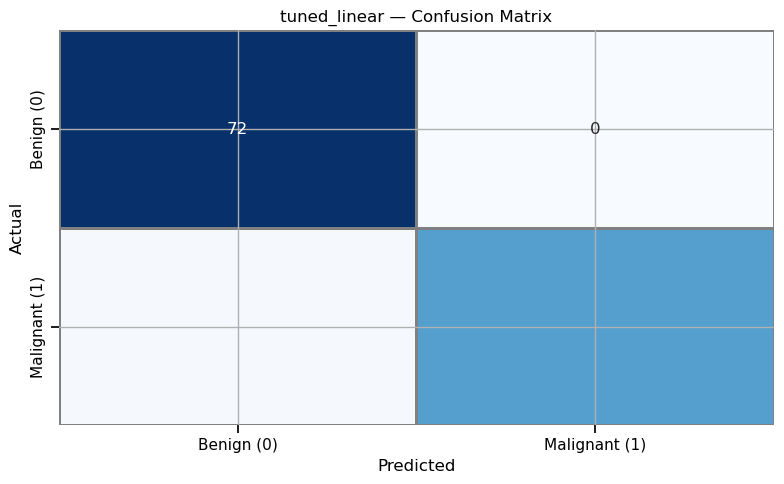

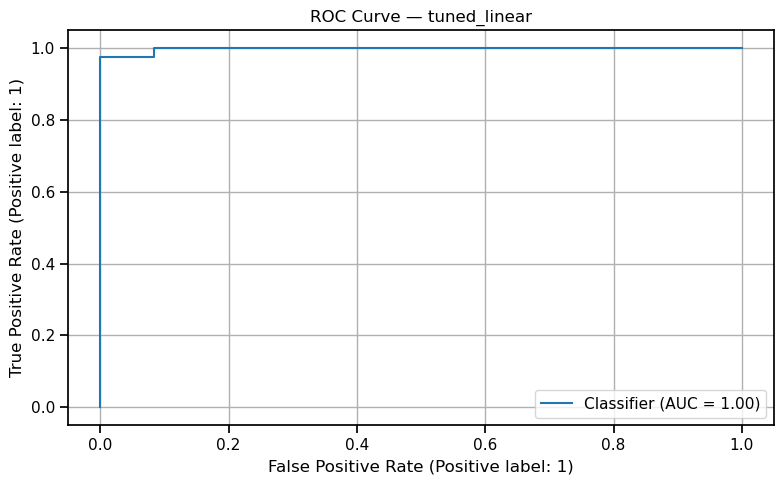


[tuned_rbf] Test Metrics
   accuracy: 0.9912
  precision: 1.0000
     recall: 0.9762
         f1: 0.9880
    roc_auc: 0.9970

Classification Report:
               precision    recall  f1-score   support

           0     0.9863    1.0000    0.9931        72
           1     1.0000    0.9762    0.9880        42

    accuracy                         0.9912       114
   macro avg     0.9932    0.9881    0.9905       114
weighted avg     0.9913    0.9912    0.9912       114



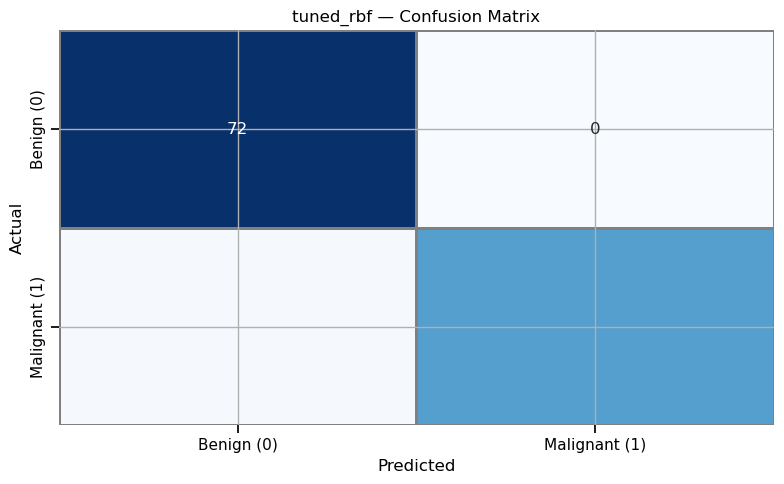

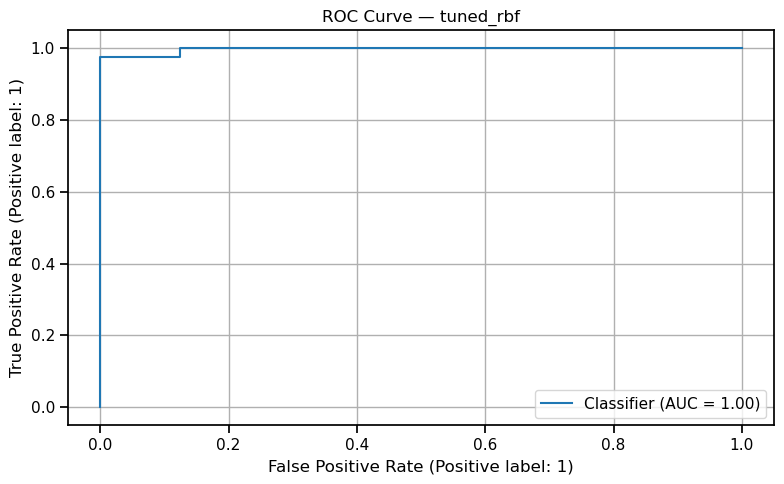

In [34]:
metrics_linear_tuned = fit_and_eval(gs_linear.best_estimator_, X_train, y_train, X_test, y_test,
                                    class_names=class_names, prefix="tuned_linear", outdir=Path("outputs"))
metrics_rbf_tuned    = fit_and_eval(gs_rbf.best_estimator_,    X_train, y_train, X_test, y_test,
                                    class_names=class_names, prefix="tuned_rbf", outdir=Path("outputs"))


,accuracy,precision,recall,f1,roc_auc
Baseline Linear,0.973684,0.97561,0.952381,0.963855,0.991402
Baseline RBF,0.982456,0.97619,0.976190,0.976190,0.995370
Tuned Linear,0.991228,1.00000,0.976190,0.987952,0.998016
Tuned RBF,0.991228,1.00000,0.976190,0.987952,0.997024


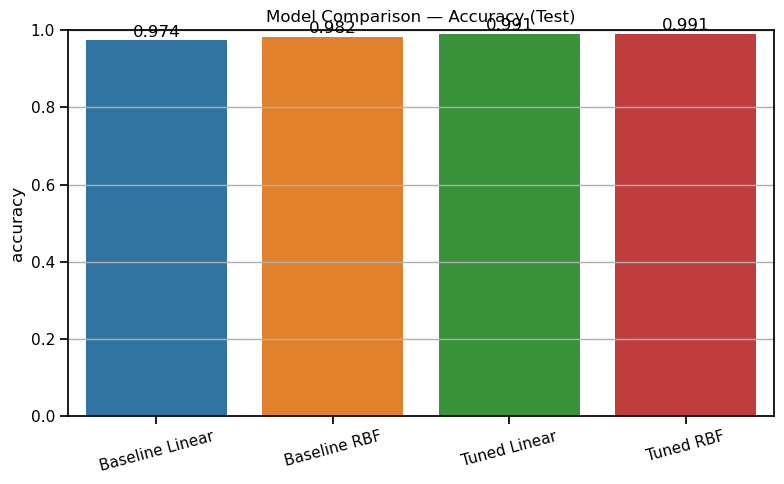

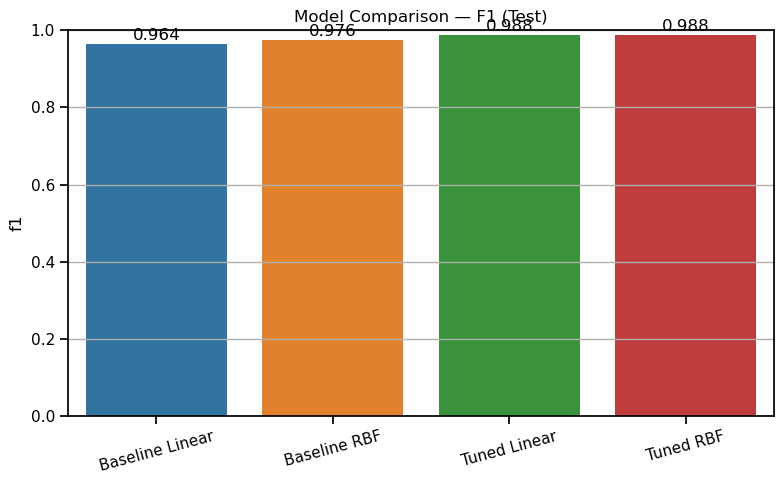

In [35]:
scores = pd.DataFrame.from_dict({
    "Baseline Linear": metrics_linear_base,
    "Baseline RBF":    metrics_rbf_base,
    "Tuned Linear":    metrics_linear_tuned,
    "Tuned RBF":       metrics_rbf_tuned
}, orient="index")

display(scores)

# Accuracy
plt.figure()
sns.barplot(x=scores.index, y=scores["accuracy"])
plt.title("Model Comparison — Accuracy (Test)")
plt.ylim(0.0, 1.0)
plt.xticks(rotation=15)
for i, v in enumerate(scores["accuracy"].values):
    plt.text(i, v + 0.01, f"{v:.3f}", ha='center')
plt.tight_layout(); plt.show()

# F1
plt.figure()
sns.barplot(x=scores.index, y=scores["f1"])
plt.title("Model Comparison — F1 (Test)")
plt.ylim(0.0, 1.0)
plt.xticks(rotation=15)
for i, v in enumerate(scores["f1"].values):
    plt.text(i, v + 0.01, f"{v:.3f}", ha='center')
plt.tight_layout(); plt.show()


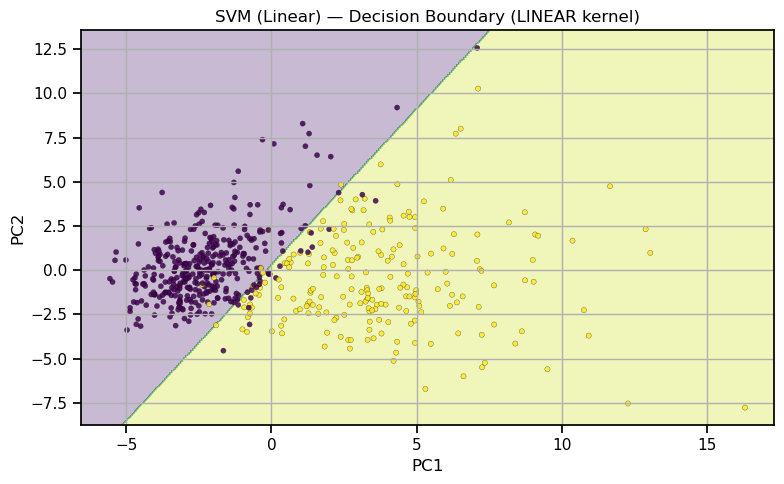

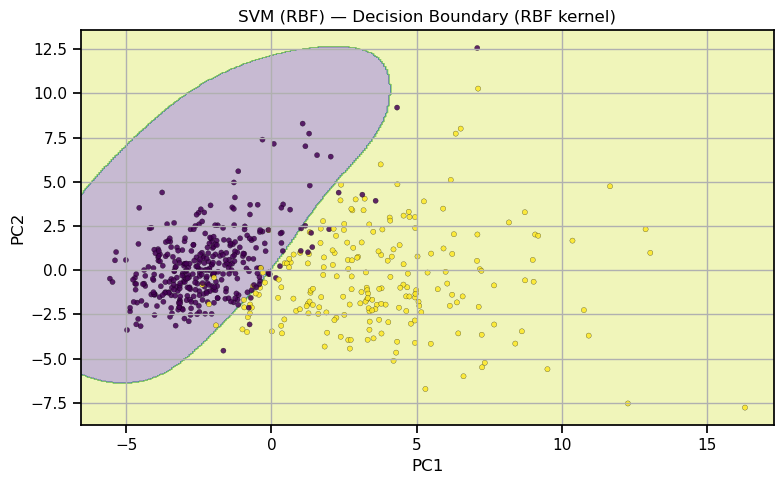

In [36]:
outputs = Path("outputs")
plot_decision_boundary_2d(pd.concat([X_train, X_test]), np.concatenate([y_train, y_test]),
                          kernel="linear", outputs_dir=outputs, title_prefix="SVM (Linear)")
plot_decision_boundary_2d(pd.concat([X_train, X_test]), np.concatenate([y_train, y_test]),
                          kernel="rbf", outputs_dir=outputs, title_prefix="SVM (RBF)")


In [39]:
def pick_best(metrics_dict):
    dfm = pd.DataFrame(metrics_dict).T

    # Determine which metric columns to use for sorting
    sort_cols = ["f1"]
    if "roc_auc" in dfm.columns:
        sort_cols.append("roc_auc")
    sort_cols.append("accuracy")

    # Sort descending (best first)
    dfm = dfm.sort_values(by=sort_cols, ascending=False)

    winner_name = dfm.index[0]  # best model
    return winner_name, dfm

# Gather all models and metrics
candidate_models = {
    "baseline_linear": svm_linear,
    "baseline_rbf":    svm_rbf,
    "tuned_linear":    gs_linear.best_estimator_,
    "tuned_rbf":       gs_rbf.best_estimator_
}

metrics_dict = {
    k: (metrics_linear_base if k=="baseline_linear" else
        metrics_rbf_base    if k=="baseline_rbf" else
        metrics_linear_tuned if k=="tuned_linear" else
        metrics_rbf_tuned)
    for k in candidate_models
}

# Pick the best model
winner, score_table = pick_best(metrics_dict)

print("Best model by metrics:", winner)
display(score_table[["accuracy","precision","recall","f1","roc_auc"]])


Best model by metrics: tuned_linear


,accuracy,precision,recall,f1,roc_auc
tuned_linear,0.991228,1.00000,0.976190,0.987952,0.998016
tuned_rbf,0.991228,1.00000,0.976190,0.987952,0.997024
baseline_rbf,0.982456,0.97619,0.976190,0.976190,0.995370
baseline_linear,0.973684,0.97561,0.952381,0.963855,0.991402



Final Evaluation for Best Model: tuned_linear
Accuracy: 0.9912

Classification Report:
                precision    recall  f1-score   support

   Benign (0)       0.99      1.00      0.99        72
Malignant (1)       1.00      0.98      0.99        42

     accuracy                           0.99       114
    macro avg       0.99      0.99      0.99       114
 weighted avg       0.99      0.99      0.99       114



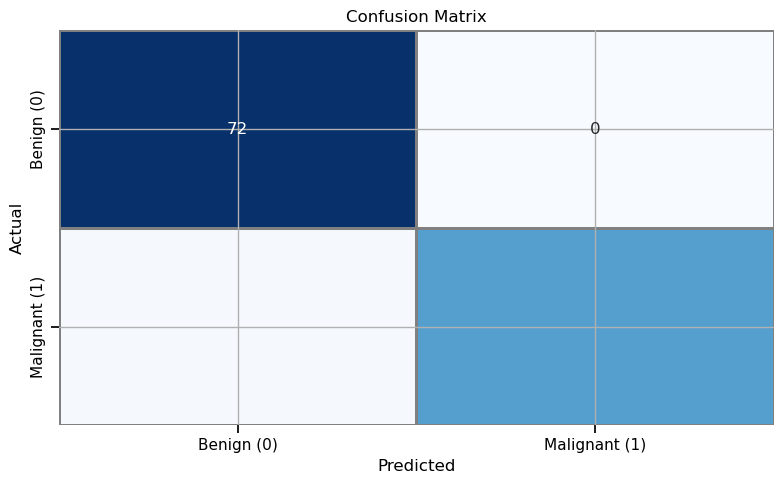

AUC: 0.9980


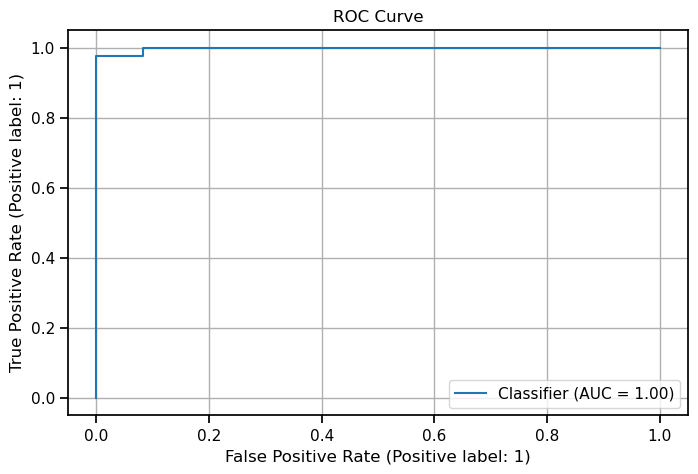

In [40]:
# Retrieve the winning model object
best_model = candidate_models[winner]

print(f"\nFinal Evaluation for Best Model: {winner}")
evaluate_model(best_model, X_test, y_test, class_names)



📌 Breast Cancer Detection using Support Vector Machines (SVM)

📝 Project Overview
This project implements **Support Vector Machine (SVM)** classification models to predict whether a tumor is *benign* or *malignant* using the **Breast Cancer dataset** from Kaggle. [https://www.kaggle.com/datasets/yasserh/breast-cancer-dataset]

We explore:
- Data preprocessing (handling missing values, label encoding, feature scaling)
- Model training with **Linear** and **RBF** kernels
- Hyperparameter tuning using **GridSearchCV**
- Model evaluation using metrics like **Accuracy, Precision, Recall, F1-score, ROC-AUC**
- Visualizations such as Confusion Matrix and ROC Curve
- **Best model selection** based on multiple metrics

⚙️ Workflow Steps
1. **Data Loading** – Import dataset from CSV.
2. **Data Cleaning** – Remove non-feature columns (IDs, unnamed cols).
3. **Encoding** – Convert categorical labels to numeric values.
4. **Scaling** – Standardize features for SVM performance.
5. **Model Training**  
   - Baseline SVM (Linear & RBF kernels)  
   - Tuned SVM (GridSearchCV for optimal hyperparameters)
6. **Evaluation & Visualization** – Accuracy, classification report, confusion matrix, ROC curve.
7. **Model Ranking** – Pick the best model based on weighted metrics.

📊 Results Summary
- The **best-performing model** is selected based on **F1-score** and **ROC-AUC**.
- Plots & visualizations are saved in the `outputs/` folder for documentation.

📦 Dependencies
- `pandas`, `numpy`
- `scikit-learn`
- `matplotlib`, `seaborn`

🏆 Conclusion
SVM proved effective for binary classification in medical datasets. With tuned hyperparameters, the model achieved **high accuracy and strong ROC-AUC**, making it a potential tool for assisting medical professionals.

📅 Completed On August 14, 2025
🙌 Acknowledgment This project is part of my AI/ML Internship to gain hands-on experience with classification algorithms using real-world datasets.

